# Basic classification: Classify images of clothing
A tensorflow serving style service example using BentoML


![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=tensorflow&ea=tensorflow_2_fashion_mnist&dt=tensorflow_2_fashion_mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
NAME = 'fashion_mnist_clipper'

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import io

# TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = _train_images / 255.0
test_images = _test_images / 255.0

In [5]:
class FashionMnist(tf.keras.Model):
    def __init__(self):
        super(FashionMnist, self).__init__()
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
    
    @staticmethod
    def image_bytes2tensor(inputs):
        inputs = tf.map_fn(lambda i: tf.io.decode_png(i, channels=1), inputs, dtype=tf.uint8)
        inputs = tf.cast(inputs, tf.float32)
        inputs = (255.0 - inputs) / 255.0
        inputs = tf.reshape(inputs, [-1, 28, 28])
        return inputs

    @tf.function(input_signature=[tf.TensorSpec(shape=(None,), dtype=tf.string)])
    def predict_image(self, inputs):
        inputs = self.image_bytes2tensor(inputs)
        return self(inputs)
    
    def call(self, inputs):
        return self.cnn(inputs)


## test the image preprocessing

Ankle boot


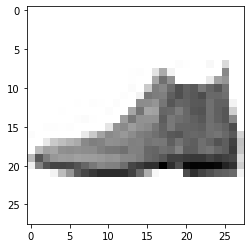

In [6]:
# pick up a test image
d_test_img = _test_images[0]
print(class_names[test_labels[0]])

plt.imshow(255.0 - d_test_img, cmap='gray')

## train the model


In [7]:
model = FashionMnist()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=1)

Train on 60000 samples
60000/60000 [==============================] - 7s 115us/sample - loss: 0.5015 - accuracy: 0.8241


# Define & save BentoService

In [8]:
%%writefile tensorflow_fashion_mnist.py

import base64
import bentoml
import tensorflow as tf
import numpy as np
from PIL import Image

from bentoml.artifact import (
    TensorflowSavedModelArtifact,
)
from bentoml.handlers import TensorflowTensorHandler, ClipperStringsHandler


FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@bentoml.env(pip_dependencies=['tensorflow', 'numpy', 'pillow'])
@bentoml.artifacts([TensorflowSavedModelArtifact('model')])
class FashionMnistTensorflow(bentoml.BentoService):

    @bentoml.api(ClipperStringsHandler)
    def predict_clipper(self, strings):
        _bytes = [base64.b64decode(i) for i in strings]
        inputs = tf.constant(_bytes, dtype=tf.string)
        outputs = self.artifacts.model.predict_image(inputs)
        output_classes = tf.math.argmax(outputs, axis=1)
        return [FASHION_MNIST_CLASSES[o] for o in output_classes]

Overwriting tensorflow_fashion_mnist.py


In [9]:
from tensorflow_fashion_mnist import FashionMnistTensorflow

bento_svc = FashionMnistTensorflow()
bento_svc.pack("model", model)
saved_path = bento_svc.save()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/bentoml-temp-h993kf1j/FashionMnistTensorflow/artifacts/model_saved_model/assets
[2020-05-15 11:26:38,651] INFO - BentoService bundle 'FashionMnistTensorflow:20200515112623_DF897F' saved to: /home/ec2-user/bentoml/repository/FashionMnistTensorflow/20200515112623_DF897F


# Build & Run Clipper Service in Docker

In [10]:
from clipper_admin import ClipperConnection, DockerContainerManager
from bentoml.clipper import deploy_bentoml
cl = ClipperConnection(DockerContainerManager())
try:
    cl.start_clipper()
except:
    cl.connect()

20-05-15:11:26:38 INFO     [docker_container_manager.py:184] [default-cluster] Starting managed Redis instance in Docker
20-05-15:11:27:07 INFO     [docker_container_manager.py:276] [default-cluster] Metric Configuration Saved at /tmp/tmp6e5gjd70.yml
20-05-15:11:27:11 INFO     [clipper_admin.py:162] [default-cluster] Clipper is running


In [11]:
NAME = saved_path.split('/')[-1].lower()
cl.register_application(NAME, 'strings', 'default_pred', 300 * 1000)

20-05-15:11:27:11 INFO     [clipper_admin.py:236] [default-cluster] Application 20200515112623_df897f was successfully registered


In [12]:
# replace PIP_INDEX_URL with your prefer pypi mirror
clipper_model_name, clipper_model_version = deploy_bentoml(
    cl, saved_path, 'predict_clipper')


[2020-05-15 11:27:12,441] INFO - Step 1/12 : FROM clipper/python36-closure-container:0.4.1
[2020-05-15 11:27:12,443] INFO - 

[2020-05-15 11:27:19,154] INFO -  ---> e5b9dc250c05

[2020-05-15 11:27:19,157] INFO - Step 2/12 : COPY . /container
[2020-05-15 11:27:19,158] INFO - 

[2020-05-15 11:27:19,606] INFO -  ---> 027249e17063

[2020-05-15 11:27:19,609] INFO - Step 3/12 : WORKDIR /container
[2020-05-15 11:27:19,610] INFO - 

[2020-05-15 11:27:19,653] INFO -  ---> Running in 7d90348e36aa

[2020-05-15 11:27:19,791] INFO -  ---> 2e01335d3241

[2020-05-15 11:27:19,792] INFO - Step 4/12 : ENV PIP_INDEX_URL=
[2020-05-15 11:27:19,793] INFO - 

[2020-05-15 11:27:19,837] INFO -  ---> Running in 78b1badc0cd1

[2020-05-15 11:27:19,954] INFO -  ---> 6d8fe97a3a93

[2020-05-15 11:27:19,958] INFO - Step 5/12 : ENV PIP_TRUSTED_HOST=
[2020-05-15 11:27:19,958] INFO - 

[2020-05-15 11:27:20,005] INFO -  ---> Running in fb9d99005007

[2020-05-15 11:27:20,118] INFO -  ---> f05813721423

[2020-05-15 11:27:2

20-05-15:11:29:33 INFO     [docker_container_manager.py:409] [default-cluster] Found 0 replicas for fashionmnisttensorflow-predict-clipper:20200515112623-df897f. Adding 1
20-05-15:11:29:34 INFO     [clipper_admin.py:724] [default-cluster] Successfully registered model fashionmnisttensorflow-predict-clipper:20200515112623-df897f
20-05-15:11:29:34 INFO     [clipper_admin.py:642] [default-cluster] Done deploying model fashionmnisttensorflow-predict-clipper:20200515112623-df897f.


In [13]:
cl.set_num_replicas(clipper_model_name, 1)
cl.link_model_to_app(NAME, clipper_model_name)

20-05-15:11:29:34 INFO     [clipper_admin.py:303] [default-cluster] Model fashionmnisttensorflow-predict-clipper is now linked to application 20200515112623_df897f


In [14]:
addr = cl.get_query_addr()
server_url = f"http://{addr}/{NAME}/predict"

# generate test requests

In [15]:
import tensorflow as tf
from io import BytesIO
import matplotlib.pyplot as plt
import base64
import json
import random


def get_request_producer():
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    url = server_url
    method = "POST"
    headers = {"content-type": "application/json"}
    pred_sentence =  "The acting was a bit lacking."

    def _gen_data():
        sio = BytesIO()
        
        d_test_img = _test_images[random.randint(0, len(_test_images) - 1)]
        label = class_names[test_labels[0]]
        plt.imsave(sio, 255.0 - d_test_img, cmap='gray')
        img_bytes = sio.getvalue()
    
        img_b64 = base64.b64encode(img_bytes).decode()

        data = json.dumps(
            {"input": img_b64}
        )
        return url, method, headers, data

    return _gen_data

# test
get_request_producer()()

('http://localhost:1337/20200515112623_df897f/predict',
 'POST',
 {'content-type': 'application/json'},
 '{"input": "iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAABzJJREFUSIm9lsdrVG8fxT+3TM/MJGrGOHHMBLFETVEJlohC9JeV4kLcuBQXrjTowj9AEdy4sKEIgghiAQUbxIUFFxYsiBIbmpgykxgzmZSZO3dued5F3vuY+OPdvnd1+/l+z/ec8zyKEELwfzz0v2+4rouqqvI6m81y+/Ztkskk27Zto6KiQj7r7u7mwoULCCHo6OigurqadevW/QtECIGiKAAo/6tD13Xp7u5m586dpFIpBgYGEEIwNjYGQKlUwjAMWlpaWLRoEd+/f6eqqoqrV68yNjZGU1PTLEAARVFQXNcVHjrA8PAw79+/J5fLUV9fz4MHD3j27BmRSIRyuUyhUMAwDOLxODU1NbKI79+/8+nTJ27evMmBAwd4+vQpS5cuRdf1WV0qtm0LVVVRFIX+/n4+f/5MKBRizpw5lEol6uvrOXv2LJcvXyaVSqGqKq7rMjIygmVZhEIh1q5dS2dnJ5WVlUxMTGCaJj6fD8uyWLJkyawxKI7jCFVVsSyLrq4u0um0fFkIgeu6pFIpCoUC/f39TExMoKoqFRUVxGIxkskk8Xic8fFxfv78SSQSIZ/PE41GsSwLx3FYvXr1H0Bvhj09PQwODpJIJDBNk2AwiGVZFItFFEUhFosRiUSIRqNyHoZhYJomuVwOVVVRVRXTNHFdF5/PRywWI5vNsmLFCuLxOK7ronvcGoZBRUUFjuOgaRq2beO6Ln6/H4CpqSkMwyCXy+E4DoqiSDXrui5VGAgEKBQKqKpKqVRCCMHQ0BDxeBxFUdC9Fz0aHMf

# Test with requests

In [16]:
import requests
url, _, headers, data = get_request_producer()()
json_response = requests.post(url, data=data, headers=headers)
print(json_response)
print(json_response.text)

<Response [200]>
{"query_id":0,"output":"Pullover","default":false}


## Benchmark

In [17]:
def verify_result(status, msg):
    if status // 100 == 2 and "default_pred" not in msg:
        return True
    return False

In [18]:
import os


def init_file(file_name):
    if os.path.exists(LOG_FILE):
        return
    with open(file_name, "a") as lf:
        lf.write('"model name","test_users","total succ","succ/sec","avg resp time",'
                 '"total fail","fail/sec","avg fail resp time","client health"')
        lf.write('\n')


def log_result(b, name, file_name, test_user):
    init_file(file_name)
    self = b.stat

    result = []
    result.append(name)
    result.append(test_user)
    result.append(self.success)
    result.append(self.success / max(self.sess_time, 1))
    result.append(sum(self.succ_times) / max(self.success, 1))

    result.append(self.fail)
    result.append(self.fail / max(self.sess_time, 1))
    result.append(sum(self.exec_times) / max(self.fail, 1))
    
    result.append((1 - self.client_busy / max(self.req_total, 1)))

    log_str = ','.join(str(r) for r in result)
    with open(file_name, "a") as lf:
        lf.write(log_str)
        lf.write('\n')

        
LOG_FILE = 'benchmark_result.csv'

In [19]:
from bentoml.utils.benchmark import BenchmarkClient
import asyncio


for TEST_USER in range(100, 1600, 100):
    b = BenchmarkClient(get_request_producer(), lambda: 1, verify_response=verify_result, timeout=0.35)
    await b._start_session(60, TEST_USER, TEST_USER)
    log_result(b, f'{NAME}', LOG_FILE, TEST_USER)
    b.killall()
    await asyncio.sleep(15)

======= Session started! =======

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │        0 │             nan │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       0 │        0 │             nan │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛
------ 100 users spawned ------

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │     182 │     89.5 │       0.0184258 │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       0 │      0   │     nan         │                  